In [1]:
import pandas as pd
import yaml
import sys
import os
from glob import glob
from pathlib import Path
import gc
import pickle

import warnings
warnings.filterwarnings('ignore')

sys.path.append('/kaggle/src')
from utils.xgb import fit_xgb
from utils.metric import compute_comptetition_metric
from utils.postprocess import post_process
from utils.set_seed import seed_base
from feature_engineering.fe_xgb import generate_features

MODEL_NAME = "xgb_model"
PACKAGE_DIR = Path("/kaggle/src")
CFG = yaml.safe_load(open(PACKAGE_DIR / "config.yaml", "r"))
print(CFG[MODEL_NAME]["execution"]["exp_id"])

CFG["output_dir"] = f"/kaggle/output/{CFG[MODEL_NAME]['execution']['exp_id']}"
!rm -r {CFG["output_dir"]}
os.makedirs(CFG["output_dir"], exist_ok=True)

seed_base(CFG["env"]["seed"])

2023-10-30 11:32:51.342830: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-10-30 11:32:51.411564: I tensorflow/core/util/port.cc:104] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-10-30 11:32:51.851286: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/cuda/lib64:/usr/local/cuda/lib:/usr/local/lib/x86_64-linux-gnu:/usr/local/nvidia/lib:/u

exp_107


In [2]:
# 特徴生成
files = glob(f"{CFG['dataset']['step_csv_dir']}/*.parquet")
train, features = generate_features(files)

# cv splitとマージ
cv_split = pd.read_csv(CFG['dataset']['cv_split_path'])
train["fold"] = train["series_id"].map(cv_split.set_index("series_id")["fold"])
display(train.head(5))
train.shape

generate features: 100%|██████████| 277/277 [04:13<00:00,  1.09it/s]


,anglez,anglez_diff_abs,anglez_diff_abs_clip5,anglez_mean,enmo,enmo_diff_abs,enmo_mean,minutes,same_count,total_seconds,...,enmo_rolling_median_100_shift_1000,anglez_diff_abs_clip5_rolling_median_100_shift_1000,enmo_std_rolling_median_100_shift_1000,anglez_diff_abs_clip5_std_rolling_median_100_shift_1000,enmo_rolling_square_mean_100_shift_1000,anglez_diff_abs_clip5_rolling_square_mean_100_shift_1000,enmo_std_rolling_square_mean_100_shift_1000,anglez_diff_abs_clip5_std_rolling_square_mean_100_shift_1000,reduce_step,fold
26,-88.176750,0.061158,0.061158,-5.381793,0.029067,0.000238,0.043929,477.5,0.0,47277.5,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,635,3
27,-88.181526,0.078712,0.078712,-12.090329,0.029175,0.000292,0.030480,597.5,0.0,47397.5,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,659,3
28,-88.507393,0.106242,0.106242,-7.547437,0.029108,0.000433,0.051443,717.5,0.0,47517.5,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,683,3
29,-89.259064,0.057546,0.057546,-10.070161,0.029858,0.000262,0.104063,837.5,0.0,47637.5,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,707,3
30,-87.457848,0.147454,0.147454,-0.726222,0.029458,0.000533,0.095024,957.5,0.0,47757.5,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,731,3


(528794, 1307)

In [3]:
# 学習
dfs = []
for event in ["wakeup", "onset"]:
    trn_oof, models = fit_xgb(
        X=train, 
        y=train[f"{event}_target"], 
        folds=train["fold"].astype(int), 
        features=features.all_features(),
        params=CFG[MODEL_NAME]["xgboost"], 
        es_rounds=100,
    )
    train["score"] = trn_oof
    train["event"] = event
    dfs.append(train[["series_id", "step", "score", "event"]])

    # 保存
    for i, model in enumerate(models):
        model.save_model(os.path.join(CFG["output_dir"], f'xgb_{event}_fold_{i}.model'))
del train
gc.collect()
train = pd.concat(dfs, axis=0)
train["step"] = train["step"].astype(int)
train = train.sort_values(["series_id", "step"]).reset_index(drop=True)


with open(os.path.join(CFG["output_dir"], "features.pkl"), "wb") as f:
    pickle.dump(features, f)
train.to_csv(os.path.join(CFG["output_dir"], "oof.csv"), index=False)

  0%|          | 0/5 [00:00<?, ?it/s]

== fold 0 ==
[0]	eval-rmse:2.16151
[100]	eval-rmse:1.37061
[200]	eval-rmse:1.17546
[300]	eval-rmse:1.12491
[400]	eval-rmse:1.11033
[500]	eval-rmse:1.10404
[600]	eval-rmse:1.10102
[700]	eval-rmse:1.09952
[800]	eval-rmse:1.09810
[900]	eval-rmse:1.09721
[1000]	eval-rmse:1.09620
[1100]	eval-rmse:1.09538
[1200]	eval-rmse:1.09484
[1300]	eval-rmse:1.09423
[1400]	eval-rmse:1.09367
[1500]	eval-rmse:1.09356
[1542]	eval-rmse:1.09362


 20%|██        | 1/5 [01:07<04:31, 67.95s/it]

== fold 1 ==
[0]	eval-rmse:2.27888
[100]	eval-rmse:1.45225
[200]	eval-rmse:1.25009
[300]	eval-rmse:1.19949
[400]	eval-rmse:1.18180
[500]	eval-rmse:1.17337
[600]	eval-rmse:1.16912
[700]	eval-rmse:1.16683
[800]	eval-rmse:1.16545
[900]	eval-rmse:1.16402
[1000]	eval-rmse:1.16293
[1100]	eval-rmse:1.16203
[1200]	eval-rmse:1.16161
[1300]	eval-rmse:1.16099
[1400]	eval-rmse:1.16056
[1500]	eval-rmse:1.16041
[1600]	eval-rmse:1.16003
[1700]	eval-rmse:1.15965
[1800]	eval-rmse:1.15933
[1900]	eval-rmse:1.15897
[2000]	eval-rmse:1.15853
[2100]	eval-rmse:1.15824
[2200]	eval-rmse:1.15784
[2300]	eval-rmse:1.15771
[2400]	eval-rmse:1.15740
[2500]	eval-rmse:1.15704
[2600]	eval-rmse:1.15668
[2700]	eval-rmse:1.15634
[2800]	eval-rmse:1.15622
[2900]	eval-rmse:1.15641
[2903]	eval-rmse:1.15641


 40%|████      | 2/5 [03:03<04:47, 95.92s/it]

== fold 2 ==
[0]	eval-rmse:2.21747
[100]	eval-rmse:1.44719
[200]	eval-rmse:1.24927
[300]	eval-rmse:1.19945
[400]	eval-rmse:1.18418
[500]	eval-rmse:1.17707
[600]	eval-rmse:1.17396
[700]	eval-rmse:1.17196
[800]	eval-rmse:1.17059
[900]	eval-rmse:1.16951
[1000]	eval-rmse:1.16849
[1100]	eval-rmse:1.16806
[1200]	eval-rmse:1.16740
[1300]	eval-rmse:1.16705
[1400]	eval-rmse:1.16664
[1500]	eval-rmse:1.16636
[1600]	eval-rmse:1.16621
[1700]	eval-rmse:1.16597
[1800]	eval-rmse:1.16581
[1900]	eval-rmse:1.16569
[2000]	eval-rmse:1.16559
[2057]	eval-rmse:1.16565


 60%|██████    | 3/5 [04:26<03:00, 90.06s/it]

== fold 3 ==
[0]	eval-rmse:2.25017
[100]	eval-rmse:1.42469
[200]	eval-rmse:1.22667
[300]	eval-rmse:1.18551
[400]	eval-rmse:1.17236
[500]	eval-rmse:1.16980
[600]	eval-rmse:1.16751
[700]	eval-rmse:1.16543
[800]	eval-rmse:1.16346
[900]	eval-rmse:1.16243
[1000]	eval-rmse:1.16225
[1100]	eval-rmse:1.16244
[1115]	eval-rmse:1.16244


 80%|████████  | 4/5 [05:17<01:14, 74.57s/it]

== fold 4 ==
[0]	eval-rmse:2.28654
[100]	eval-rmse:1.46701
[200]	eval-rmse:1.26449
[300]	eval-rmse:1.20951
[400]	eval-rmse:1.19206
[500]	eval-rmse:1.18386
[600]	eval-rmse:1.17922
[700]	eval-rmse:1.17719
[800]	eval-rmse:1.17537
[900]	eval-rmse:1.17397
[1000]	eval-rmse:1.17344
[1100]	eval-rmse:1.17322
[1200]	eval-rmse:1.17322
[1300]	eval-rmse:1.17292
[1400]	eval-rmse:1.17282
[1500]	eval-rmse:1.17262
[1600]	eval-rmse:1.17218
[1700]	eval-rmse:1.17204
[1800]	eval-rmse:1.17211
[1814]	eval-rmse:1.17206


  0%|          | 0/5 [00:00<?, ?it/s]

== fold 0 ==
[0]	eval-rmse:2.15698
[100]	eval-rmse:1.37786
[200]	eval-rmse:1.18614
[300]	eval-rmse:1.13642
[400]	eval-rmse:1.11920
[500]	eval-rmse:1.11214
[600]	eval-rmse:1.10881
[700]	eval-rmse:1.10711
[800]	eval-rmse:1.10574
[900]	eval-rmse:1.10495
[1000]	eval-rmse:1.10445
[1100]	eval-rmse:1.10408
[1200]	eval-rmse:1.10365
[1300]	eval-rmse:1.10328
[1400]	eval-rmse:1.10299
[1500]	eval-rmse:1.10273
[1600]	eval-rmse:1.10256
[1700]	eval-rmse:1.10239
[1800]	eval-rmse:1.10238
[1872]	eval-rmse:1.10259


 20%|██        | 1/5 [01:13<04:53, 73.33s/it]

== fold 1 ==
[0]	eval-rmse:2.27821
[100]	eval-rmse:1.45028
[200]	eval-rmse:1.24101
[300]	eval-rmse:1.18193
[400]	eval-rmse:1.16086
[500]	eval-rmse:1.15110
[600]	eval-rmse:1.14675
[700]	eval-rmse:1.14388
[800]	eval-rmse:1.14200
[900]	eval-rmse:1.13998
[1000]	eval-rmse:1.13795
[1100]	eval-rmse:1.13634
[1200]	eval-rmse:1.13553
[1300]	eval-rmse:1.13446
[1400]	eval-rmse:1.13388
[1500]	eval-rmse:1.13332
[1600]	eval-rmse:1.13264
[1700]	eval-rmse:1.13264
[1800]	eval-rmse:1.13205
[1900]	eval-rmse:1.13210
[1903]	eval-rmse:1.13210


 40%|████      | 2/5 [02:31<03:49, 76.38s/it]

== fold 2 ==
[0]	eval-rmse:2.21662
[100]	eval-rmse:1.44748
[200]	eval-rmse:1.25429
[300]	eval-rmse:1.20100
[400]	eval-rmse:1.18306
[500]	eval-rmse:1.17406
[600]	eval-rmse:1.17021
[700]	eval-rmse:1.16691
[800]	eval-rmse:1.16502
[900]	eval-rmse:1.16321
[1000]	eval-rmse:1.16231
[1100]	eval-rmse:1.16154
[1200]	eval-rmse:1.16131
[1300]	eval-rmse:1.16022
[1400]	eval-rmse:1.15958
[1500]	eval-rmse:1.15920
[1600]	eval-rmse:1.15907
[1700]	eval-rmse:1.15900
[1800]	eval-rmse:1.15865
[1900]	eval-rmse:1.15831
[2000]	eval-rmse:1.15767
[2100]	eval-rmse:1.15759
[2200]	eval-rmse:1.15755
[2244]	eval-rmse:1.15762


 60%|██████    | 3/5 [03:59<02:43, 81.66s/it]

== fold 3 ==
[0]	eval-rmse:2.24815
[100]	eval-rmse:1.46679
[200]	eval-rmse:1.29079
[300]	eval-rmse:1.24952
[400]	eval-rmse:1.24004
[500]	eval-rmse:1.23481
[600]	eval-rmse:1.23228
[700]	eval-rmse:1.23077
[800]	eval-rmse:1.22937
[900]	eval-rmse:1.22895
[959]	eval-rmse:1.22898


 80%|████████  | 4/5 [04:44<01:07, 67.18s/it]

== fold 4 ==
[0]	eval-rmse:2.28290
[100]	eval-rmse:1.49660
[200]	eval-rmse:1.31310
[300]	eval-rmse:1.26799
[400]	eval-rmse:1.25365
[500]	eval-rmse:1.24685
[600]	eval-rmse:1.24329
[700]	eval-rmse:1.24061
[800]	eval-rmse:1.23895
[900]	eval-rmse:1.23766
[1000]	eval-rmse:1.23643
[1100]	eval-rmse:1.23524
[1200]	eval-rmse:1.23412
[1300]	eval-rmse:1.23332
[1400]	eval-rmse:1.23284
[1500]	eval-rmse:1.23269
[1600]	eval-rmse:1.23250
[1700]	eval-rmse:1.23240
[1800]	eval-rmse:1.23202
[1900]	eval-rmse:1.23217
[1957]	eval-rmse:1.23213


100%|██████████| 5/5 [06:02<00:00, 72.58s/it]


## Dynamic-Range NMS

<AxesSubplot: >

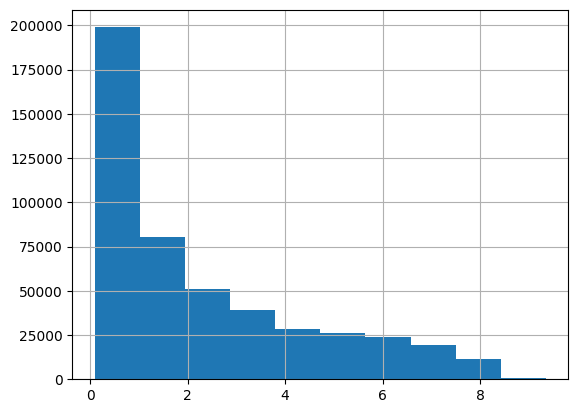

In [4]:
train = train[train["score"] > 0.1]
train["score"].hist()

In [5]:
from utils.postprocess import dynamic_range_nms
from multiprocessing import Pool
from tqdm import tqdm

train["step"] = train["step"].astype(int)

groups = [group for _, group in train.groupby("series_id")]
with Pool(30) as p:  
    results = list(tqdm(p.imap(dynamic_range_nms, groups), total=len(groups)))
sub = pd.concat(results)
sub["score"] = sub["reduced_score"]

100%|██████████| 277/277 [00:10<00:00, 26.33it/s]


In [6]:
# スコア計算
labels = pd.read_csv(f"{CFG['dataset']['competition_dir']}/train_events.csv").dropna()
score, ap_table = compute_comptetition_metric(labels, sub)

print(f"score: {score:.4f}")
display(ap_table)
sub.to_csv(os.path.join(CFG["output_dir"], "submission_after_nms.csv"), index=False)

score: 0.7596


event   tolerance
onset   12           0.178169
        36           0.580136
        60           0.742076
        90           0.809568
        120          0.839797
        150          0.860157
        180          0.872227
        240          0.890556
        300          0.897970
        360          0.904774
wakeup  12           0.166878
        36           0.603432
        60           0.742452
        90           0.806996
        120          0.838603
        150          0.862046
        180          0.876924
        240          0.895305
        300          0.907110
        360          0.917441
dtype: float64